In [1]:
import numpy as np 
from scipy.fft import dct
from scipy.linalg import fractional_matrix_power
from group_lasso import GroupLasso
import copy

from matplotlib import pyplot as plt
from itertools import combinations  
from tqdm import tqdm 

import warnings
warnings.filterwarnings("ignore")

# Step 1 - Synthetic graph aligning the subspaces
## Finding isometries between orthonormal basis

In [2]:
class SyntheticGrassmanGraph:
    def __init__(
            self, 
            V, 
            d, 
            basis,
            seed,
            mode,
            E0 = None,
            tau = None
    ):
        '''
        A class implementing our graph model based on the alignment of linear vector subspaces
        Attributes:
            V: int ->           Number of nodes
            d: int ->           Nodes stalks dimension
            basis: np.array ->  A complete dictionary (we usually use DCT) for the stalk on the nodes (we consider R^d without loss of generality)
            seed: int ->        Random seed for reproducibility
            mode: str ->        Mode for the generation of the graph, 
                                either "boolean" if based on cardinality constrained programming 
                                or "geometric" if based on thresholding the post-alignemnt distance
            E0: int ->          Prior assumption on the number of edges
            tau: float ->       Threshold for the geometric graph
        Methods:
            subpaceAssignment   Randomly assign to each node a linear subspace of R^d with dimension sampled uniformly at random between 1 and d
            Procrustes          Compute the orthogonal Procrustes solution to the alignment problem ||F_uD_u - F_vD_v||_F^2
            alignment           Perform the alignment between each pair of subspaces
            inference           Carries out a graph based on one of the two mode as a set of edges
        '''

        assert V >= d
        assert mode in ['Geometric','Boolean']

        self.V = V
        self.d = d
        self.E0 = E0
        self.tau = tau
        self.basis = basis
        self.seed = seed
        self.mode = mode

        self.subSpaceAssignment()
        self.alignment()

    def subSpaceAssignment(self):
        
        # Randomly generating subspaces spanned by subsets of the shared basis
        self.SS = {v: np.random.choice(self.d, np.random.choice(np.arange(1,self.d), 1), replace = False) for v in range(self.V)}

        # Preallocating basis for such subspaces
        self.DS = {
            v: np.hstack([self.basis[:,self.SS[v]], np.zeros((self.d, self.d - len(self.SS[v])))])
            for v in range(self.V)
        }
        
    def Procrustes(self, u, v):
        
        D_u = self.DS[u]
        D_v = self.DS[v]

        # Procrustes solution to the alignment problem is based on SVD of the cross product between the basis of the two spaces to be aligned
        X, _, Y = np.linalg.svd(D_v @ D_u.T)
        F_u = X @ Y
        F_v = np.eye(self.d)

        return F_u, F_v, D_u, D_v
    
    def alignment(self):

        # Perform the alignment and store the distance after this operation
        self.dists = {}
        self.Fs = {edge: {
            edge[0]: None, 
            edge[1]: None
        } for edge in list(combinations(range(self.V), 2))}
        
        for (u,v) in list(combinations(range(self.V), 2)):
            F_u, F_v, D_u, D_v = self.Procrustes(u,v)
            self.Fs[(u,v)][u] = F_u
            self.Fs[(u,v)][v] = F_v
            self.dists[(u,v)] = np.linalg.norm(F_u @ D_u - F_v @ D_v)
    
    def inference(self):
        
        # Edge-set-cardinality based graph -> Sort the Dirichlet energies and keep the first E0
        if self.mode == 'Boolean':
            sorted_edges = sorted(self.dists.items(), key=lambda x:x[1])
            return list(map(lambda x: x[0], sorted_edges[:self.E0]))

        # Alignment-distance-thresholding based graph -> Keep the subset of edges whose Dirichlet energy is below the threshold tau
        if self.mode == 'Geometric':
            filtered_edges = filter(lambda x: x[1] <= self.tau, self.dists.items())
            return list(map(lambda x: x[0], filtered_edges))


In [3]:
# Example utilization

d = 64
B = dct(np.eye(d), axis=0, norm='ortho').T
G = SyntheticGrassmanGraph(64, 64, B, 42, 'Boolean', 100, 0)

# Step 2a - Generating signals showing local group sparsity without noise

In [161]:
class SyntheticSignals:
    def __init__(self, basis, V, d, seed, snaps):
        '''
        A class for generating possibly noisy signals with a covariance structure lying on different linear subspaces
        Attributes:
            V: int ->               Number of nodes
            d: int ->               Nodes stalks dimension
            SNR: float ->           Signal-to-noise ratio (db)
            seed: int ->            Random seed for reproducibility
            snaps: int ->           Number of signals observed in each subspace
        Methods:
            subpaceAssignment       Randomly assign to each node a linear subspace of R^d with dimension sampled uniformly at random between 1 and d
            random_crosscov         Generates a random crosscovariance matrix with a specific block-sparsity pattern
            random_coefficients     Generates gaussian distributed coefficients for the sparse construction of signals 
            noise                   Generates noise with a given SNR
            normalize               Performs L2 normalization 
            signals_generation      Generates signals accordingly to precomputed basis and spectrum 
        '''

        self.basis = basis
        self.V = V
        self.d = d
        self.seed = seed
        self.snaps = snaps
        self.generated = False
        
        self.subspace_assignment()
        self.random_crosscov()
        self.random_coefficients()
                
    def subspace_assignment(self):

        self.SS = {v: np.random.choice(self.d, np.random.choice(np.arange(1,self.d), 1), replace = False) for v in range(self.V)}
        self.dims = {v:len(self.SS[v]) for v in range(self.V)}

    def random_crosscov(self, scale = 1):
        
        self.dim = np.sum(list(self.dims.values()))

        # Generate a random positive spectrum
        eigenvalues = np.random.exponential(scale, self.dim)

        # Use QR decomposition on a matrix with random entries to get an orthonormal basis
        Q, _ = np.linalg.qr(np.random.randn(self.dim, self.dim))

        # Build a covariance matrix using the computed spectrum and orthonormal basis
        self.C = Q @ np.diag(eigenvalues) @ Q.T
        '''
        self.Cs = {(u,v): None for (u,v) in list(combinations(range(self.V),2))}

        # Map all the blocks of the covariance matrix for further operations
        start_i = 0
        for i, di in list(self.dims.items()):
            start_j = start_i + di  # Upper triangular starts after the diagonal block
            for j, dj in list(self.dims.items())[i+1:]:
                end_i = start_i + di
                end_j = start_j + dj
                self.Cs[(i,j)] = self.C[start_i:end_i, start_j:end_j]
                start_j = end_j
            start_i += di
        '''

    def random_coefficients(self):
        
        # Generate a stack of all the coefficients leveraging the imposed covariance structure
        self.S = self.C @ np.random.randn(self.dim, self.snaps)

        # Map back all the coefficients ot each node
        self.coeffs = {v: None for v in range(self.V)}
        start = 0
        for v in range(self.V):
            end = start + self.dims[v]
            self.coeffs[v] = self.S[start:end, :]
            start = end
    
    def noise(self, signal, SNR):

        if SNR is None:
            return np.zeros_like(signal)

        signal_power = np.mean(np.square(signal), axis=0, keepdims=True)
        snr_linear = 10 ** (SNR / 10)
        noise_power = signal_power / snr_linear

        noise = np.sqrt(noise_power) * np.random.randn(*signal.shape)
        return noise
    
    
    def normalize(self, signal):

        return signal / np.linalg.norm(signal, axis=0)
    
    def signals_generation(self, SNR):
        
        # Finally we leverage the structure we impose to generate signals
        np.random.seed(self.seed)
        self.signals = {
            node: (
                signal := self.normalize(self.basis[:,self.SS[node]] @ self.coeffs[node]))
             + self.noise(signal, SNR)
            for node in range(self.V)
        }

        self.generated = True
    
    def sparse_coder(self, alpha):

        def prox21_col(x):
                
            return ( 1 - alpha / (np.max([np.linalg.norm(x), alpha])) ) * x
        
        def prox21(X):

            X = np.apply_along_axis(prox21_col, axis = 1, arr = X)
            return X

        def ProxGradDescent(node, LR = 3e-3, MAXITER = 1000, eps = 1e-2):
            S = np.zeros((self.d, self.snaps))
            loss = np.inf

            for _ in range(MAXITER):
                # Gradient update: x_new = x_old + step_size * D^T (y - D * x_old)
                gradient = self.basis.T @ self.basis @ S - self.basis.T @ self.signals[node]
                S = S - LR * gradient
                
                # Hard thresholding: keep only the k largest entries
                S = prox21(S)
                
                temp = np.linalg.norm(self.signals[node] - self.basis @ S)
                if loss - temp < eps:
                    break
                else:
                    loss = temp
            return S
        
        if self.generated:
            coder = {v: np.zeros((self.d, self.snaps)) for v in range(self.V)}
            for node in range(self.V):
                coder[node] = ProxGradDescent(node)
            return coder
        else:
            return 'Before sparsifying you should generate signals :)'

In [120]:
# Example utilization

d = 64
B = dct(np.eye(d), axis=0, norm='ortho').T
X = SyntheticSignals(B, 64, 64, 42, 100)

In [121]:
X.signals_generation(None)

In [124]:
X.sparse_coder(0.001)

{0: array([[ 0.10196099,  0.13790006,  0.10918728, ..., -0.02194604,
          0.08729946, -0.13760795],
        [-0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.03323268,  0.04272972, -0.08543685, ...,  0.14158624,
         -0.07408987, -0.12539696],
        ...,
        [-0.        , -0.        , -0.        , ...,  0.        ,
          0.        , -0.        ],
        [ 0.        ,  0.        , -0.        , ...,  0.        ,
          0.        , -0.        ],
        [-0.        , -0.        ,  0.        , ..., -0.        ,
         -0.        ,  0.        ]]),
 1: array([[ 0., -0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0., -0., ...,  0.,  0., -0.],
        [ 0., -0.,  0., ...,  0., -0.,  0.],
        ...,
        [ 0., -0.,  0., ..., -0., -0.,  0.],
        [-0.,  0., -0., ..., -0., -0., -0.],
        [-0., -0.,  0., ...,  0., -0.,  0.]]),
 2: array([[ 0.03382704,  0.04641954,  0.08535674, ...,  0.07873132,
          0.0

# Step 2b - Repeating the graph construction in a data driven way 

In [ ]:
class DataDrivenGrassmanGraph:
    def __init__(
            self, 
            V, 
            d,
            X,
            basis,
            seed
    ):
        '''
        This class should implement the same idea of subspace alignment 
        but through a data-driven apoproach, i.e. using observed signals and not basis for subspaces (still under modeling phase)
        Attributes:
            V: int ->               Number of nodes
            d: int ->               Nodes stalks dimension
            X: SyntheticSignals ->  An instantiated object of the SyntheticSignals class
            seed: int ->            Random seed for reproducibility
            mode: str ->            Mode for the generation of the graph, 
                                    either "boolean" if based on cardinality constrained programming 
                                    or "geometric" if based on thresholding the post-alignemnt distance
            tau: float ->           Threshold for the geometric graph
        Methods:
            Procrustes              Compute the orthogonal Procrustes solution to the data-driven alignment problem ||F_u X_u - F_v X_v||_F^2
            alignment               Perform the alignment between each pair of subspaces
            inference               Carries out a graph based on one of the two mode as a set of edges
        '''
        assert V >= d

        self.V = V
        self.d = d

        self.X = X
        self.basis = basis
  
        self.seed = seed

    def Procrustes(self, u, v, codebook = None):
        if codebook is None:
            S_u = self.X.coeffs[u]
            S_v = self.X.coeffs[v]
            D_u = self.basis[:,self.X.SS[u]]
            D_v = self.basis[:,self.X.SS[v]]
            
        else:
            S_u = codebook[u]
            S_v = codebook[v]
            D_u = self.basis
            D_v = self.basis
            
        # We use the empirical cross covariance
        C_uv = S_u @ S_v.T / self.X.snaps

        X, _, Y = np.linalg.svd(D_u @ C_uv @ D_v.T, full_matrices=False)
        F_u = Y.T @ X.T
        F_v = np.eye(self.d)

        return F_u, F_v, D_u @ S_u, D_v @ S_v
    
    def alignment(self, codebook = None):
        
        self.pre_dists = {}
        self.post_dists = {}
        self.Fs = {edge: {
                    edge[0]: None, 
                    edge[1]: None
                } for edge in list(combinations(range(self.V), 2))}
                
        self.dims_diff = {}
        
        for (u,v) in list(combinations(range(self.V), 2)):
            F_u, F_v, S_u, S_v = self.Procrustes(u, v, codebook)
            self.pre_dists[(u,v)] = np.linalg.norm(S_u - S_v) ** 2 / self.X.snaps
            self.post_dists[(u,v)] = np.linalg.norm(F_u @ S_u - F_v @ S_v) ** 2 / self.X.snaps
            self.Fs[(u,v)][u] = F_u
            self.Fs[(u,v)][v] = F_v
            self.dims_diff[(u,v)] = np.abs(len(self.X.SS[u]) - len(self.X.SS[v]))
            
    def inference(self):
        
        return {
            'Pre': list(sorted(self.pre_dists.items(), key=lambda x:x[1])),
            'Post': list(sorted(self.post_dists.items(), key=lambda x:x[1]))
        }


In [168]:
d = 64
V = 64
B = dct(np.eye(d), axis=0, norm='ortho').T

X = SyntheticSignals(B, V, d, 42, 1000)

G = DataDrivenGrassmanGraph(V, d, X, B, 42)
G.alignment()

In [181]:
X.C.shape 

(2195, 2195)

In [174]:
_, L, _ = np.linalg.svd(X.coeffs[0] @ X.coeffs[1].T / X.snaps)

In [175]:
L

array([1.05388945, 0.9153961 , 0.82731518, 0.67904278, 0.59711797,
       0.57206721, 0.49032818, 0.46411282, 0.4516645 , 0.39607034,
       0.35318472, 0.28843523, 0.2757289 , 0.23181092, 0.19726581,
       0.17179577, 0.10254028])

In [166]:
G.pre_dists

{(0, 1): np.float64(198.40125506620853),
 (0, 2): np.float64(115.78584874302346),
 (0, 3): np.float64(108.70644925099577),
 (0, 4): np.float64(180.59552573721962),
 (0, 5): np.float64(218.3015814616625),
 (0, 6): np.float64(208.5588181467102),
 (0, 7): np.float64(151.95980259474416),
 (0, 8): np.float64(178.80336618267128),
 (0, 9): np.float64(197.72069113957528),
 (0, 10): np.float64(153.9272504811461),
 (0, 11): np.float64(196.04636611623997),
 (0, 12): np.float64(148.58697220293632),
 (0, 13): np.float64(152.33164342425403),
 (0, 14): np.float64(124.1545636784521),
 (0, 15): np.float64(168.0951372948731),
 (0, 16): np.float64(163.30887355166982),
 (0, 17): np.float64(152.55031170473276),
 (0, 18): np.float64(249.54571012940374),
 (0, 19): np.float64(139.11605654017325),
 (0, 20): np.float64(105.25498428721468),
 (0, 21): np.float64(224.16161028832116),
 (0, 22): np.float64(218.30411914888842),
 (0, 23): np.float64(153.79897094412087),
 (0, 24): np.float64(185.48662726534653),
 (0, 2

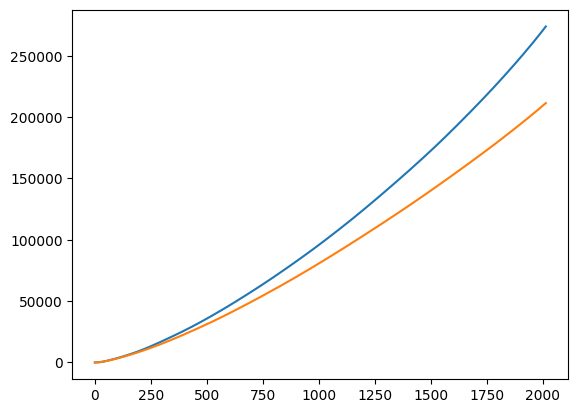

In [169]:
TVs_pre = []
TVs_post = []

TVS = G.inference()

for E0 in range(1, len(list(combinations(range(V),2)))):
    TVs_pre.append(np.sum([TVS['Pre'][i][1] for i in range(0,E0)]))
    TVs_post.append(np.sum([TVS['Post'][i][1] for i in range(0,E0)]))

plt.plot(TVs_pre)
plt.plot(TVs_post)

___

# Step 3 - Parametrize the construction wrt the SNR 


- Run a sparse coder on each node to get rid of the noise
- Run the inferential procedure

In [145]:
SNRs = [5,25]

In [146]:
SNRs = [5,25]
alphas = [0.001, 0.005,0.01,0.05]

codebook = {
    alpha: {
        SNR: None for SNR in SNRs
    } for alpha in alphas
}

In [147]:
d = 64
V = 64
B = dct(np.eye(d), axis=0, norm='ortho').T

In [153]:
X = SyntheticSignals(B, V, d, 42, 1000)

In [154]:
for alpha in alphas:
    for SNR in tqdm(SNRs):
        X.signals_generation(SNR)
        codebook[alpha][SNR] = X.sparse_coder(alpha)

100%|██████████| 2/2 [00:00<00:00,  3.88it/s]


In [155]:
G = DataDrivenGrassmanGraph(V, d, X, B, 42)

In [156]:
dists = {
    alpha: {
        SNR: None for SNR in SNRs
    } for alpha in alphas
}

for alpha in alphas:
    for SNR in SNRs:
        G.alignment(codebook[alpha][SNR])
        dists[alpha][SNR] = copy.copy(G.inference())

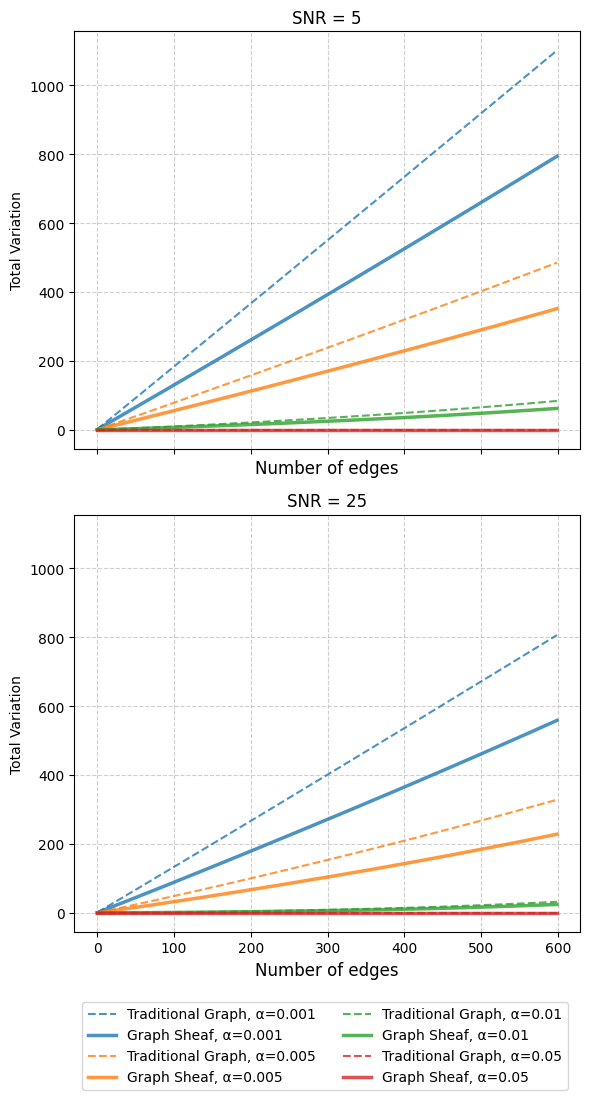

In [157]:
# Define a color map for the alphas
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# Determine grid layout (2x1) for subplots
rows, cols = 2, 1
fig, axes = plt.subplots(rows, cols, figsize=(6, 10), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten for easier indexing

# Iterate over SNRs and plot on subplots
for i, SNR in enumerate(SNRs[:2]):
    ax = axes[i]  # Current subplot
    for j, alpha in enumerate(alphas):
        TVs_pre = []
        TVs_post = []

        TVS = dists[alpha][SNR]

        # Calculate cumulative sums for Pre and Post
        for E0 in range(1, len(list(combinations(range(V), 2))))[:600]:
            TVs_pre.append(np.sum([TVS['Pre'][k][1] for k in range(0, E0)]))
            TVs_post.append(np.sum([TVS['Post'][k][1] for k in range(0, E0)]))

        # Plot Pre (dashed line) and Post (solid, thicker line) with the same color
        ax.plot(
            TVs_pre,
            label=f'Traditional Graph, α={alpha}',
            color=colors[j],
            linestyle='--',
            linewidth=1.5,
            alpha=0.8,
        )
        ax.plot(
            TVs_post,
            label=f'Graph Sheaf, α={alpha}',
            color=colors[j],
            linestyle='-',
            linewidth=2.5,  # Thicker line for Post
            alpha=0.8,
        )

    # Add dashed grid, title, and labels
    ax.grid(linestyle='--', alpha=0.6)
    ax.set_title(f'SNR = {SNR}')
    ax.set_ylabel('Total Variation')
    ax.set_xlabel('Number of edges', fontsize=12)

# Add common x-label, y-label
plt.xlabel('Number of edges', fontsize=12)
plt.tight_layout()

# Add a single legend outside the grid, centered below the plot
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels, loc='upper center', bbox_to_anchor=(0.55, -0.001), ncol=2, fontsize=10
)

plt.show()


In [ ]:

# Define a color map for the alphas
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# First plot (only the first SNR, no legend)
fig1, ax1 = plt.subplots(figsize=(6, 5))

# Iterate over the first SNR and plot on the first subplot
SNR = SNRs[0]
for j, alpha in enumerate(alphas):
    TVs_pre = []
    TVs_post = []

    TVS = dists[alpha][SNR]

    # Calculate cumulative sums for Pre and Post
    for E0 in range(1, len(list(combinations(range(V), 2))))[:1000]:
        TVs_pre.append(np.sum([TVS['Pre'][k][1] for k in range(0, E0)]))
        TVs_post.append(np.sum([TVS['Post'][k][1] for k in range(0, E0)]))

    # Plot Pre (dashed line) and Post (solid, thicker line) with the same color
    ax1.plot(
        TVs_pre,
        label=f'Traditional Graph, α={alpha}',
        color=colors[j],
        linestyle='--',
        linewidth=1.5,
        alpha=0.8,
    )
    ax1.plot(
        TVs_post,
        label=f'Graph Sheaf, α={alpha}',
        color=colors[j],
        linestyle='-',
        linewidth=2.5,  # Thicker line for Post
        alpha=0.8,
    )

# Add dashed grid, title, and labels
ax1.grid(linestyle='--', alpha=0.6)
ax1.set_title(f'SNR = {SNR}')
ax1.set_ylabel('Total Variation')
ax1.set_xlabel('Number of edges', fontsize=12)

# Adjust layout and save first figure
plt.tight_layout()
fig1.savefig('figure_1_no_legend.png', bbox_inches='tight')
plt.close(fig1)

# Second plot (only the second SNR, with legend)
fig2, ax2 = plt.subplots(figsize=(6, 5))

# Iterate over the second SNR and plot on the second subplot
SNR = SNRs[1]
for j, alpha in enumerate(alphas):
    TVs_pre = []
    TVs_post = []

    TVS = dists[alpha][SNR]

    # Calculate cumulative sums for Pre and Post
    for E0 in range(1, len(list(combinations(range(V), 2))))[:1000]:
        TVs_pre.append(np.sum([TVS['Pre'][k][1] for k in range(0, E0)]))
        TVs_post.append(np.sum([TVS['Post'][k][1] for k in range(0, E0)]))

    # Plot Pre (dashed line) and Post (solid, thicker line) with the same color
    ax2.plot(
        TVs_pre,
        label=f'Traditional Graph, α={alpha}',
        color=colors[j],
        linestyle='--',
        linewidth=1.5,
        alpha=0.8,
    )
    ax2.plot(
        TVs_post,
        label=f'Graph Sheaf, α={alpha}',
        color=colors[j],
        linestyle='-',
        linewidth=2.5,  # Thicker line for Post
        alpha=0.8,
    )

# Add dashed grid, title, and labels
ax2.grid(linestyle='--', alpha=0.6)
ax2.set_title(f'SNR = {SNR}')
ax2.set_ylabel('Total Variation')
ax2.set_xlabel('Number of edges', fontsize=12)

# Add the legend to the second plot (outside the plot area)
handles, labels = ax2.get_legend_handles_labels()
fig2.legend(
    handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=len(alphas)
)

# Adjust layout so both plots have the same size
fig2.subplots_adjust(bottom=0.15)  # Increase bottom margin to fit the legend

# Adjust layout and save second figure
plt.tight_layout()
fig2.savefig('figure_2_with_legend.png', bbox_inches='tight')
plt.close(fig2)

# Now you have two separate images saved:
# 'figure_1_no_legend.png' and 'figure_2_with_legend.png'


In [10]:
class SyntheticConnectionGraph:
    def __init__(self, V, d, E0, basis):
        self.V = V
        self.d = d
        self.E0 = E0 
        self.basis = basis
        self.sheaf = SyntheticGrassmanGraph(V, d, basis, 42, 'Boolean', E0)    

        self.B = np.zeros((self.d * self.E0, self.d * self.V))

        for i, edge in tqdm(enumerate(self.sheaf.inference())): 
            self.B[i*self.d:(i+1)*self.d, edge[0]*self.d:(edge[0]+1)*self.d] = self.sheaf.Fs[edge][edge[0]]
            self.B[i*self.d:(i+1)*self.d, edge[1]*self.d:(edge[1]+1)*self.d] = - self.sheaf.Fs[edge][edge[1]]
        
        self.L = self.B.T @ self.B
        
        '''
        self.L = (fractional_matrix_power(np.diag(np.diagonal(self.L)), -0.5) @ 
                  self.L @ 
                  fractional_matrix_power(np.diag(np.diagonal(self.L)), -0.5))
        '''


In [11]:
B = dct(np.eye(d), axis=0, norm='ortho').T
G = SyntheticConnectionGraph(64, 64, 120, B)

120it [00:00, 11386.22it/s]
